In [2]:
import seaborn as sns
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import ast
import numpy as np
import matplotlib.colors as mcolors

In [6]:
config = configparser.ConfigParser()
config.read('configs.ini')
# result_file_directory = "../results/experiment1 20240813-1321.csv"
# result_file_directory = "../results/experiment1 20240824-1434.csv"
result_file_directory = "../results/experiment1 20240825-1734.csv"
df = pd.read_csv(result_file_directory)

In [7]:
def safe_eval(model_str):
    try:
        model = ast.literal_eval(model_str)
        if isinstance(model, list):
            return model
    except (ValueError, SyntaxError):
        pass
    return model_str

def generate_label(method, model):
    if method == "Dummy" and model == "Dummy":
        return "Dummy"
    Method_number = "Method 1" if method == "different models" else "Method 2" if method == "different data" else "Method 3"
    model_ = safe_eval(model)
    
    if isinstance(model_, str):
        model_name = "Tree" if "Tree" in model else "Regression" if "Regression" in model else "KNN"
    else:
        first_model = "Tree" if "Tree" in model_[0] else "Regression" if "Regression" in model_[0] else "KNN"
        second_model = "Tree" if "Tree" in model_[1] else "Regression" if "Regression" in model_[1] else "KNN"
        model_name = first_model +"+"+ second_model
    return Method_number + " " + model_name

df['Initial Brier'] = df['Initial Brier'].apply(safe_eval)
df['Final Brier'] = df['Final Brier'].apply(safe_eval)
df['Method_Model_Label'] = df.apply(lambda row: generate_label(row['Method'], row['Models']), axis=1)

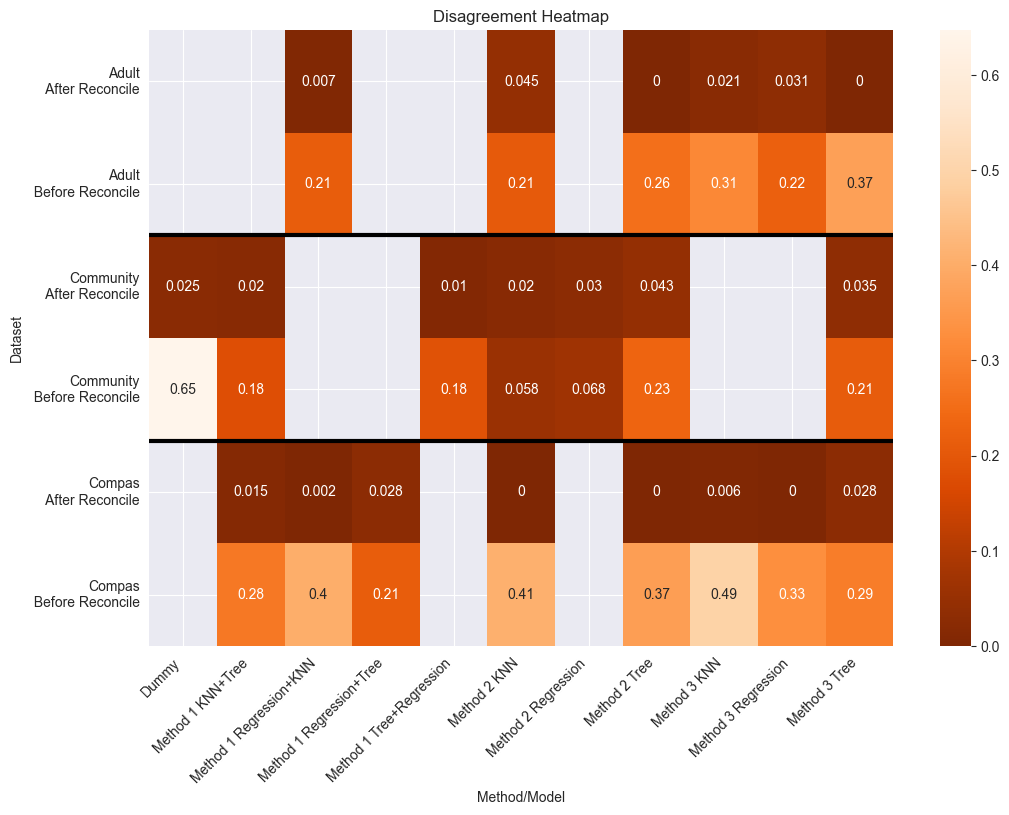

In [8]:
plot_data = pd.DataFrame({
    'Disagreement': df['Initial Disagreement'].tolist() + df['Final Disagreement'].tolist(),
    'Dataset': [f"{name.replace('_Data','')}\n Before Reconcile" for name in df['Data']] + [f"{name.replace('_Data','')}\n After Reconcile" for name in df['Data']],
    'Method/Model': df['Method_Model_Label'].tolist() * 2
})
# Pivot the data for heatmap
heatmap_data =plot_data.pivot(index="Dataset", columns="Method/Model", values="Disagreement")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap="Oranges_r")
plt.title("Disagreement Heatmap")
plt.xticks(rotation=45, ha='right')
# cmap.set_bad('black')
for idx in range(2, len(heatmap_data.index), 2):
    ax.hlines(idx, *ax.get_xlim(), color='black', linewidth=3)
plt.show()

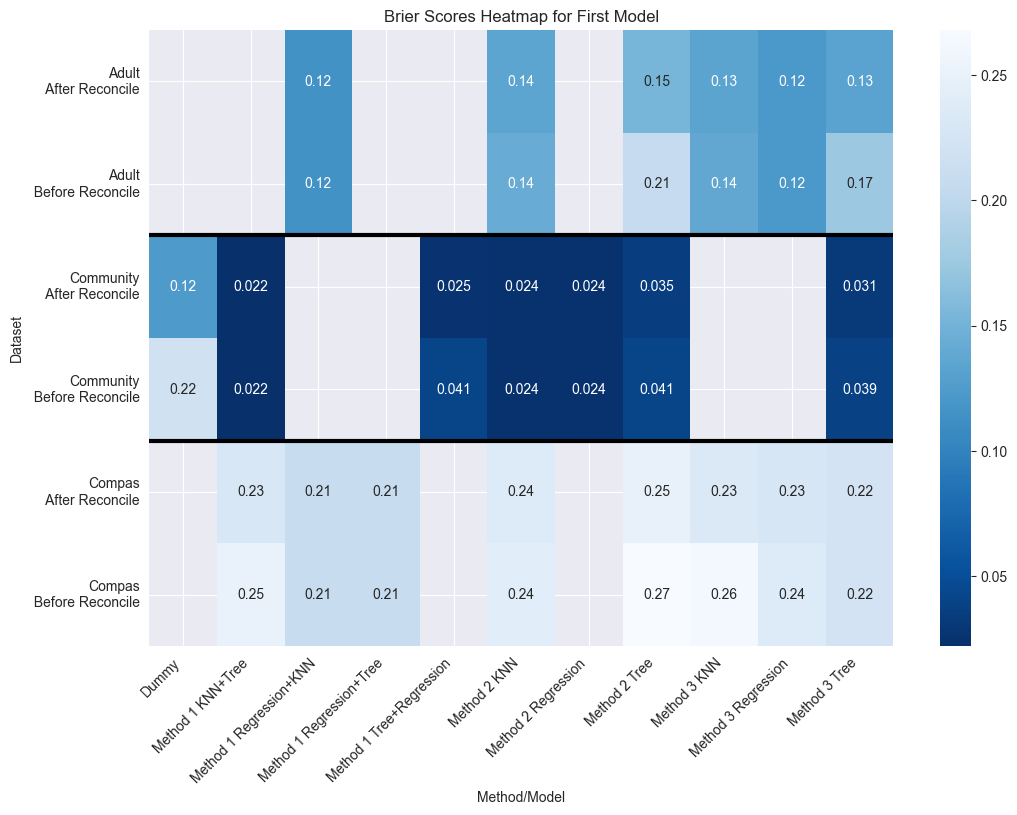

In [9]:
plot_data = pd.DataFrame({
    'Brier Score': [scores[0] for scores in df['Initial Brier']] + [scores[0] for scores in df['Final Brier']],
    'Dataset': [f"{name.replace('_Data','')}\n Before Reconcile" for name in df['Data']] + [f"{name.replace('_Data','')}\n After Reconcile" for name in df['Data']],
    'Method/Model': df['Method_Model_Label'].tolist() * 2
})

# Pivot the data for heatmap
heatmap_data =plot_data.pivot(index="Dataset", columns="Method/Model", values="Brier Score")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap="Blues_r")
plt.title("Brier Scores Heatmap for First Model")
plt.xticks(rotation=45, ha='right')
# cmap.set_bad('black')
for idx in range(2, len(heatmap_data.index), 2):
    ax.hlines(idx, *ax.get_xlim(), color='black', linewidth=3)
plt.show()

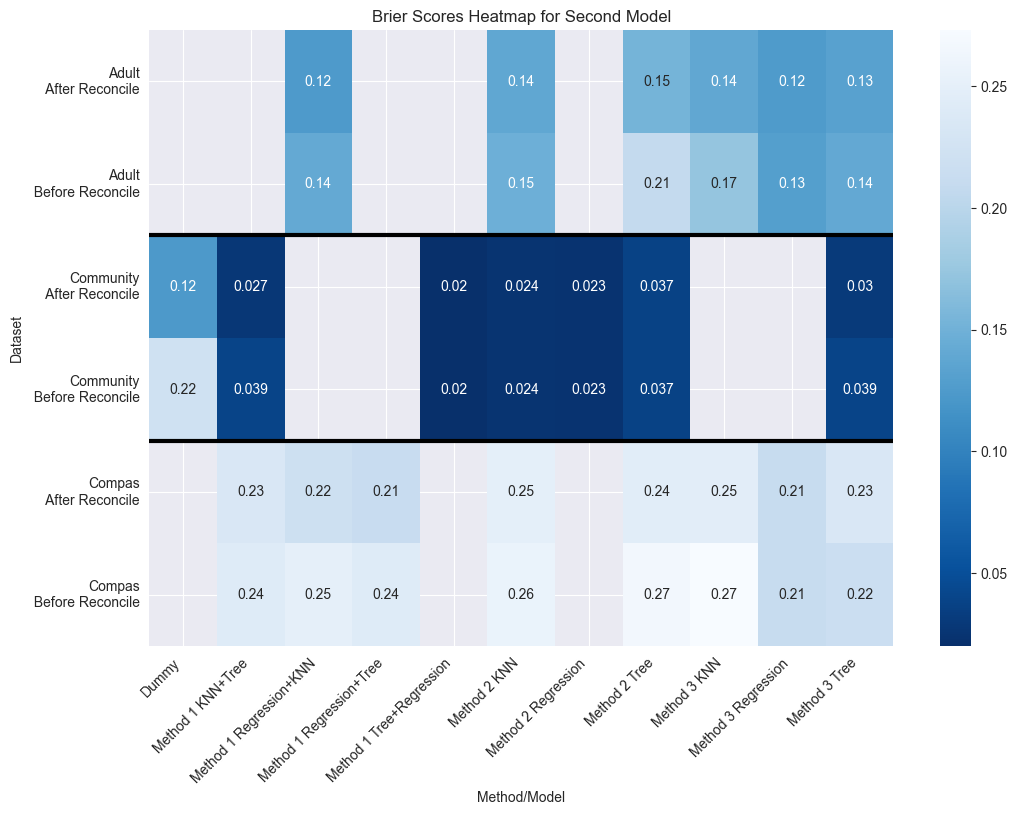

In [10]:
plot_data = pd.DataFrame({
    'Brier Score': [scores[1] for scores in df['Initial Brier']] + [scores[1] for scores in df['Final Brier']],
    'Dataset': [f"{name.replace('_Data','')}\n Before Reconcile" for name in df['Data']] + [f"{name.replace('_Data','')}\n After Reconcile" for name in df['Data']],
    'Method/Model': df['Method_Model_Label'].tolist() * 2
})

# Pivot the data for heatmap
heatmap_data =plot_data.pivot(index="Dataset", columns="Method/Model", values="Brier Score")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap="Blues_r")
plt.title("Brier Scores Heatmap for Second Model")
plt.xticks(rotation=45, ha='right')
# cmap.set_bad('black')
for idx in range(2, len(heatmap_data.index), 2):
    ax.hlines(idx, *ax.get_xlim(), color='black', linewidth=3)
plt.show()

In [3]:
df = pd.read_csv('../results/experiment1 final.csv')
df['Data'] = df['Data'].str.replace('_Data$', '', regex=True)

In [8]:
# df['T'] = df['T1'] + df['T2']
# df['T'].describe()
# df['T_bound'] = df['Theorem 3.1'].str.extract(r'1\.\s*\d+\s*<=\s*(\d+\.?\d*)')
df['T_bound'] = df['T_bound'].astype(float)
df['T_bound'].describe()
# groups = df[df['Method'] == 'different data'].groupby(['Data']).count()

count    4517.000000
mean     2817.461147
std      1178.982103
min       344.000000
25%      2192.000000
50%      3064.000000
75%      3728.000000
max      5256.000000
Name: T_bound, dtype: float64

In [9]:
df_filtered = df[df['Method'] == 'different data']
df_sampled = df_filtered.groupby('Data').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

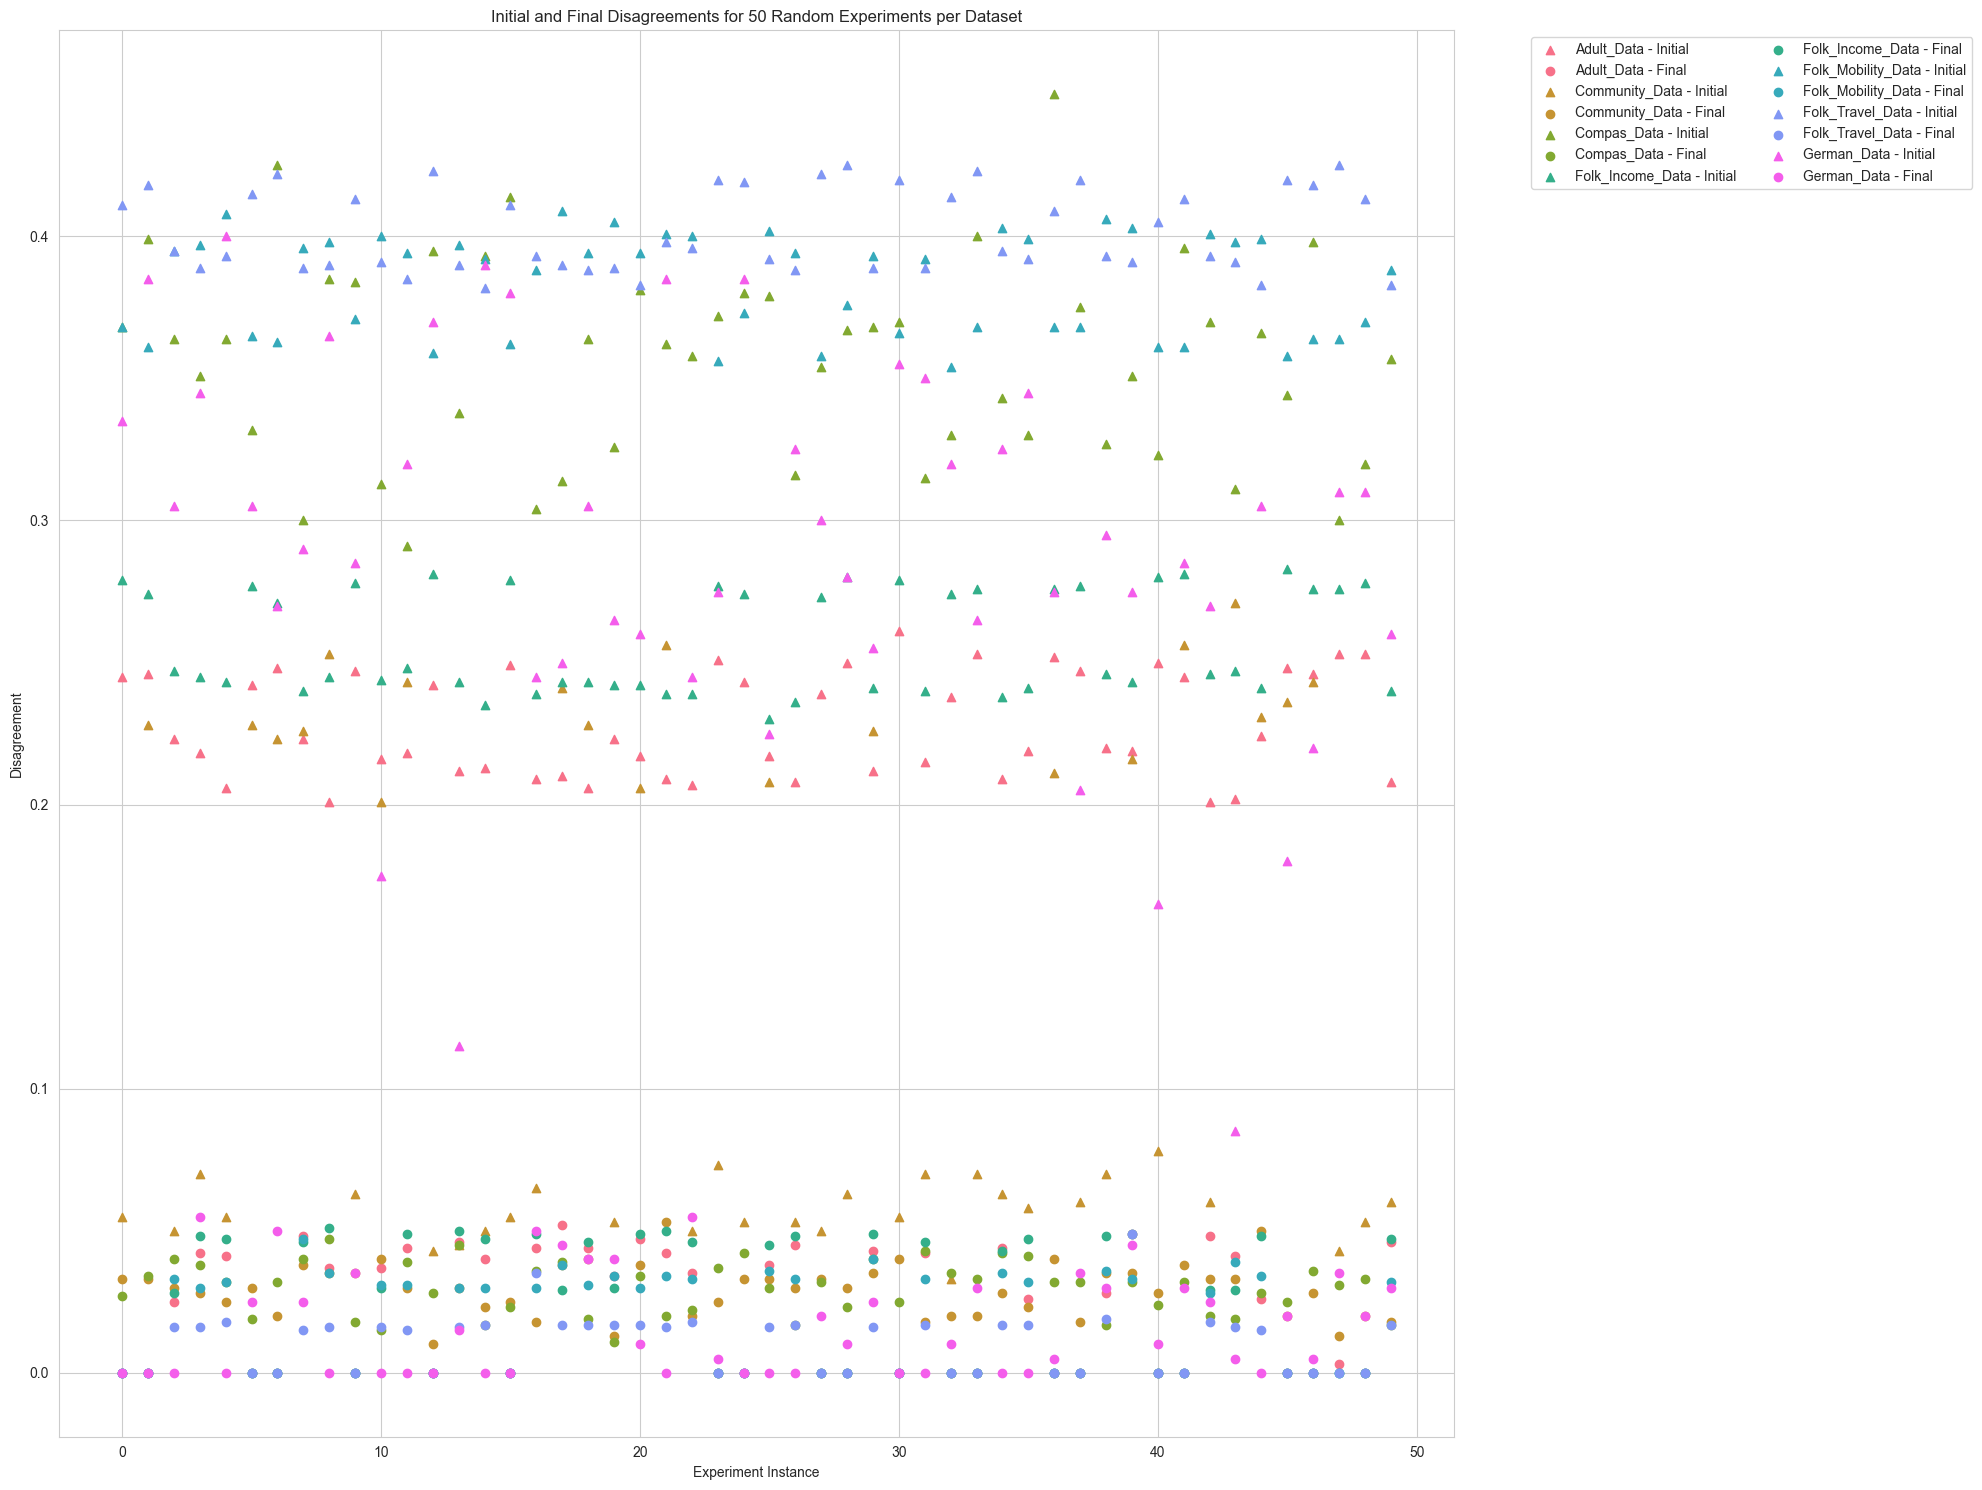

In [10]:
palette = sns.color_palette("husl", n_colors=7) 
plt.figure(figsize=(20, 15))
for dataset, color in zip(df_sampled['Data'].unique(), palette):
    data_subset = df_sampled[df_sampled['Data'] == dataset]
    plt.scatter(x=np.arange(len(data_subset)), y=data_subset['Initial Disagreement'], 
                marker='^', label=f'{dataset} - Initial', color=color)
    
    # Plot Final Disagreement (circle markers)
    plt.scatter(x=np.arange(len(data_subset)), y=data_subset['Final Disagreement'], 
                marker='o', label=f'{dataset} - Final', color=color)

# Add labels and title
plt.xlabel('Experiment Instance')
plt.ylabel('Disagreement')
plt.title('Initial and Final Disagreements for 50 Random Experiments per Dataset')

# Add a legend
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=2)

# Display the plot
plt.tight_layout()
plt.show()

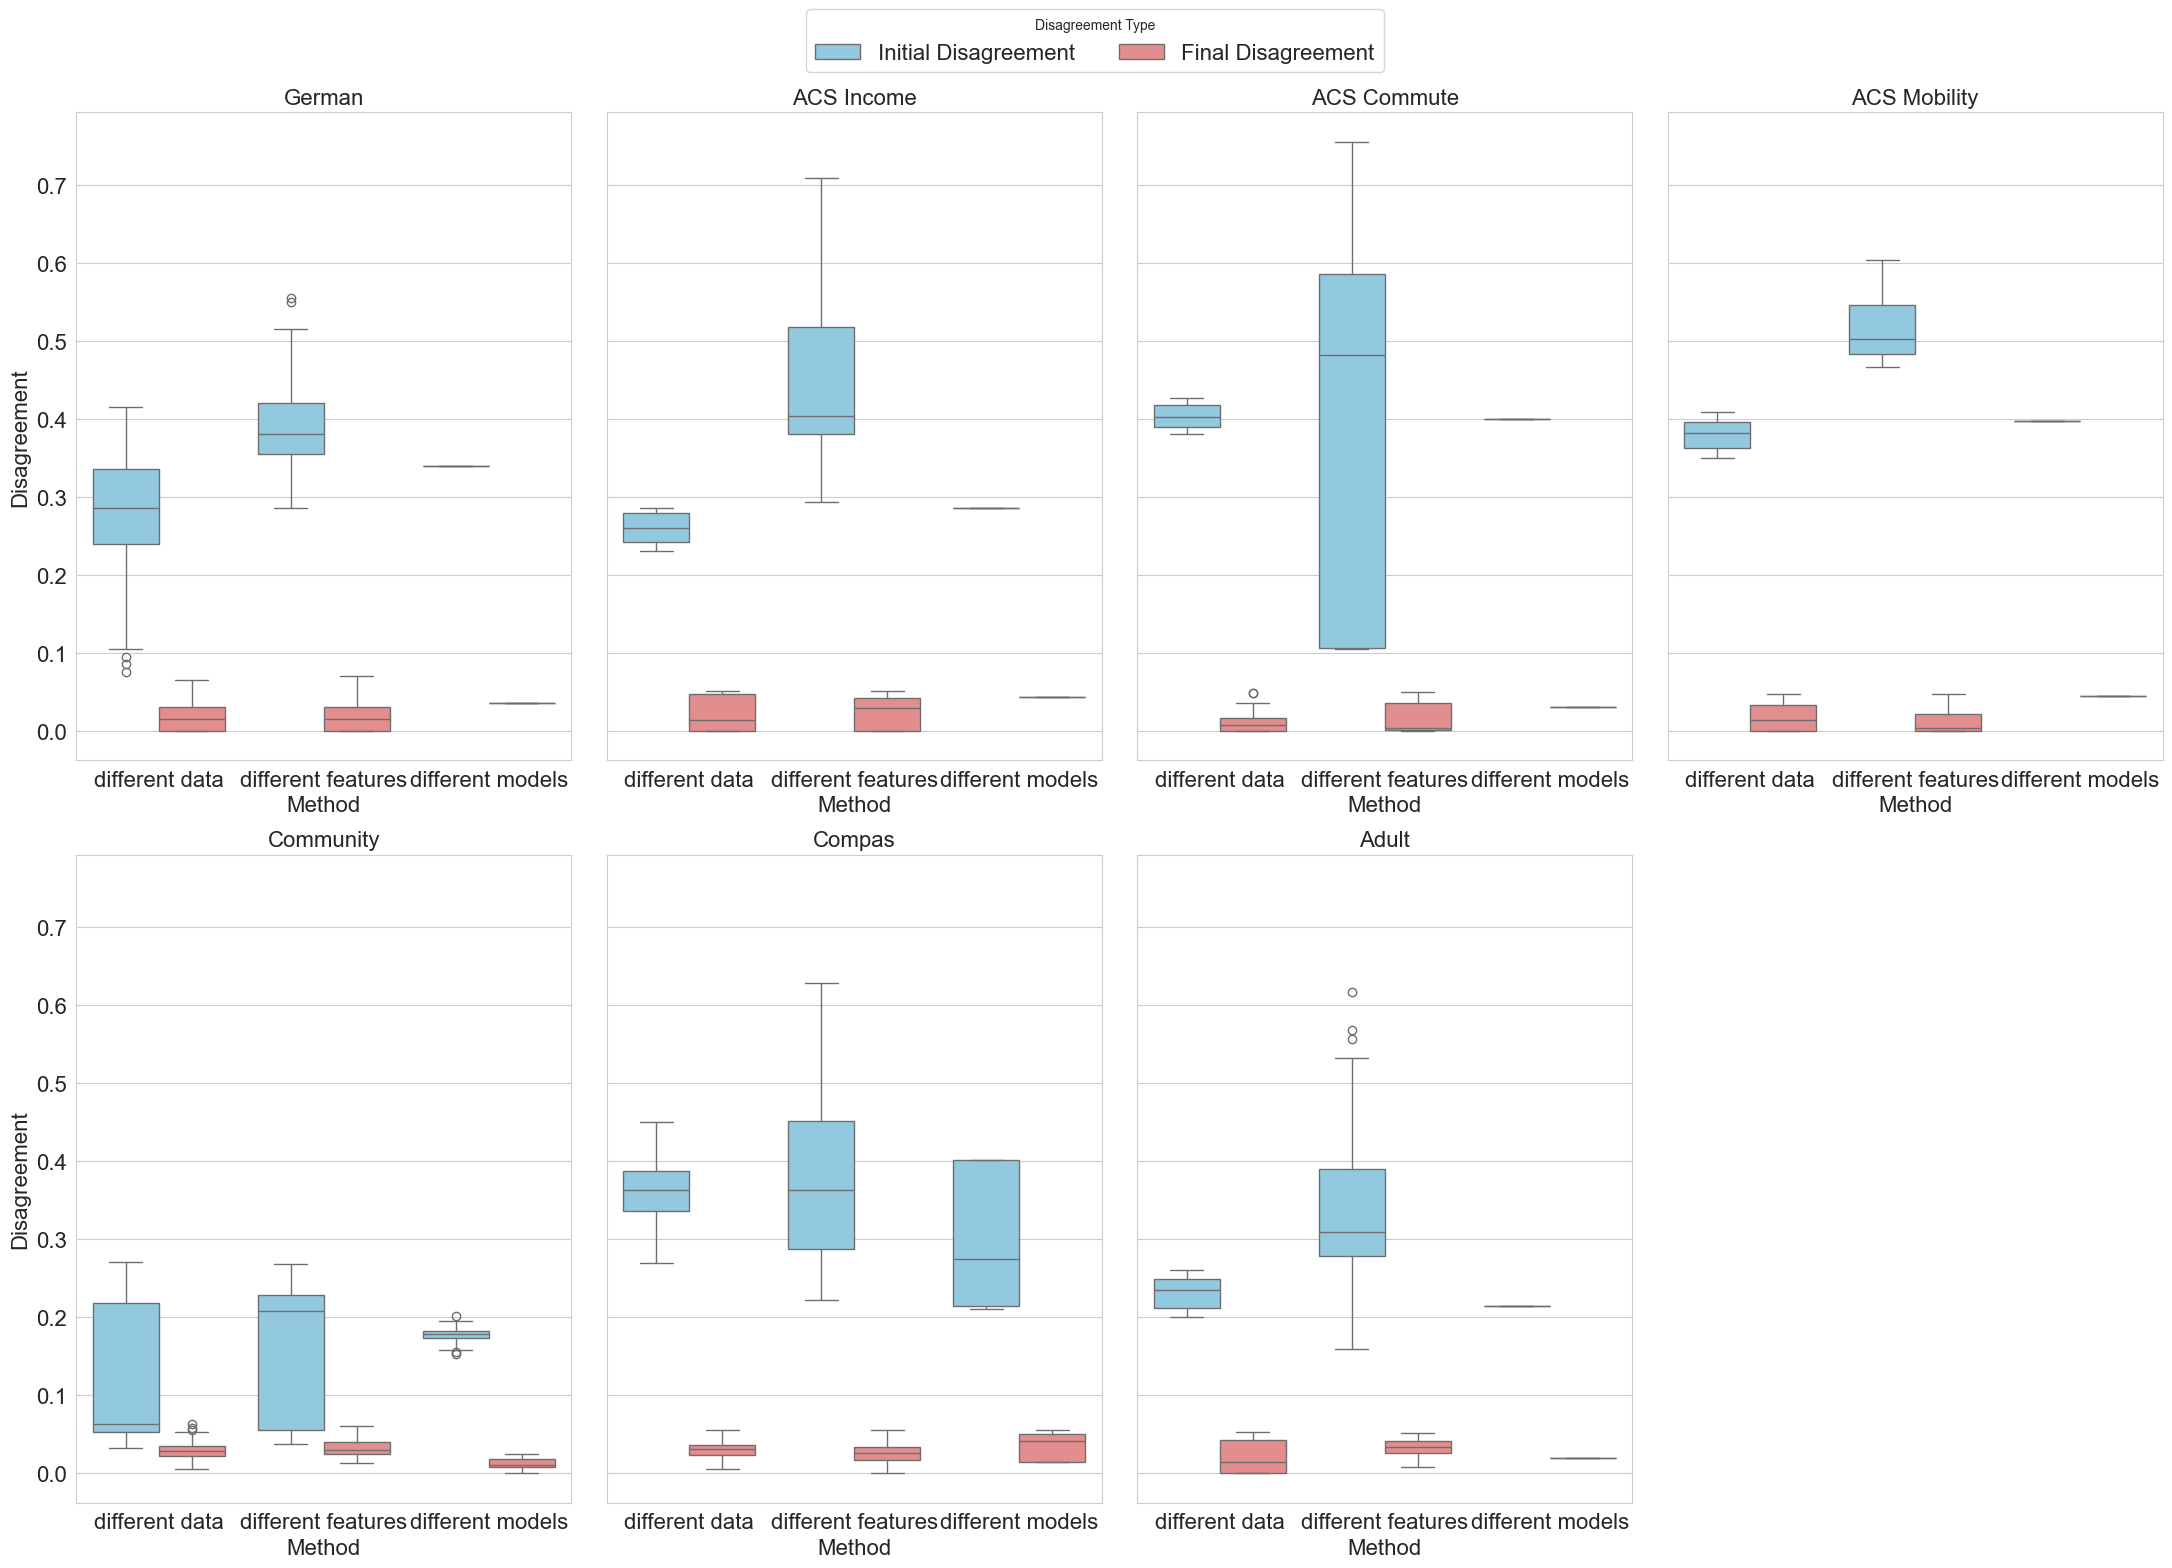

In [26]:
mapping_dict = {
    'Folk_Mobility': 'ACS Mobility',
    'Folk_Income': 'ACS Income',
    'Folk_Travel': 'ACS Commute'
}
df = df[df['Method'] != 'Dummy']
df['Data'] = df['Data'].replace(mapping_dict)
datasets = df['Data'].unique()

# Set up the figure and subplots: 7 subplots for 7 datasets (arranged in a grid, e.g., 2 rows and 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(22, 15), sharey=True)  # 2x4 grid (even though we only need 7)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define colors for Initial and Final Disagreements
initial_color = 'skyblue'
final_color = 'lightcoral'

# Loop over each dataset and plot the corresponding boxplots
for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Filter the dataframe for the current dataset
    df_subset = df[df['Data'] == dataset]
    
    # Reshape the data for box plotting (to create separate boxplots for Initial and Final Disagreement)
    df_melted = pd.melt(df_subset, id_vars=['Method'], 
                        value_vars=['Initial Disagreement', 'Final Disagreement'], 
                        var_name='Disagreement Type', value_name='Disagreement')
    
    # Plot the boxplots using seaborn
    sns.boxplot(x='Method', y='Disagreement', hue='Disagreement Type', data=df_melted, 
                ax=ax, palette={'Initial Disagreement': initial_color, 'Final Disagreement': final_color})
    
    # Set the title for each subplot
    ax.set_title(f'{dataset}', fontsize=16)
    
    # Set labels for each subplot
    ax.set_xlabel('Method', fontsize=16)
    ax.set_ylabel('Disagreement', fontsize=16)
# ax.legend(title="Legend Title", fontsize=12, title_fontsize=14)
    # Remove the legend for individual plots (we'll add a global one later)
    ax.get_legend().remove()

# Turn off the 8th (extra) subplot, as we only need 7
if len(axes) > len(datasets):
    fig.delaxes(axes[-1])
    # fig.delaxes(axes[-2])# This removes the 8th axis

# Adjust layout to fit everything nicely
plt.tight_layout()

# Add a global legend (for the whole figure) that differentiates Initial vs Final Disagreement
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Disagreement Type', bbox_to_anchor=(0.5, 1.05), fontsize=16)
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['xtick.labelsize'] = 16  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size
plt.rcParams['axes.titlesize'] = 16 
# Show the plot
plt.show()

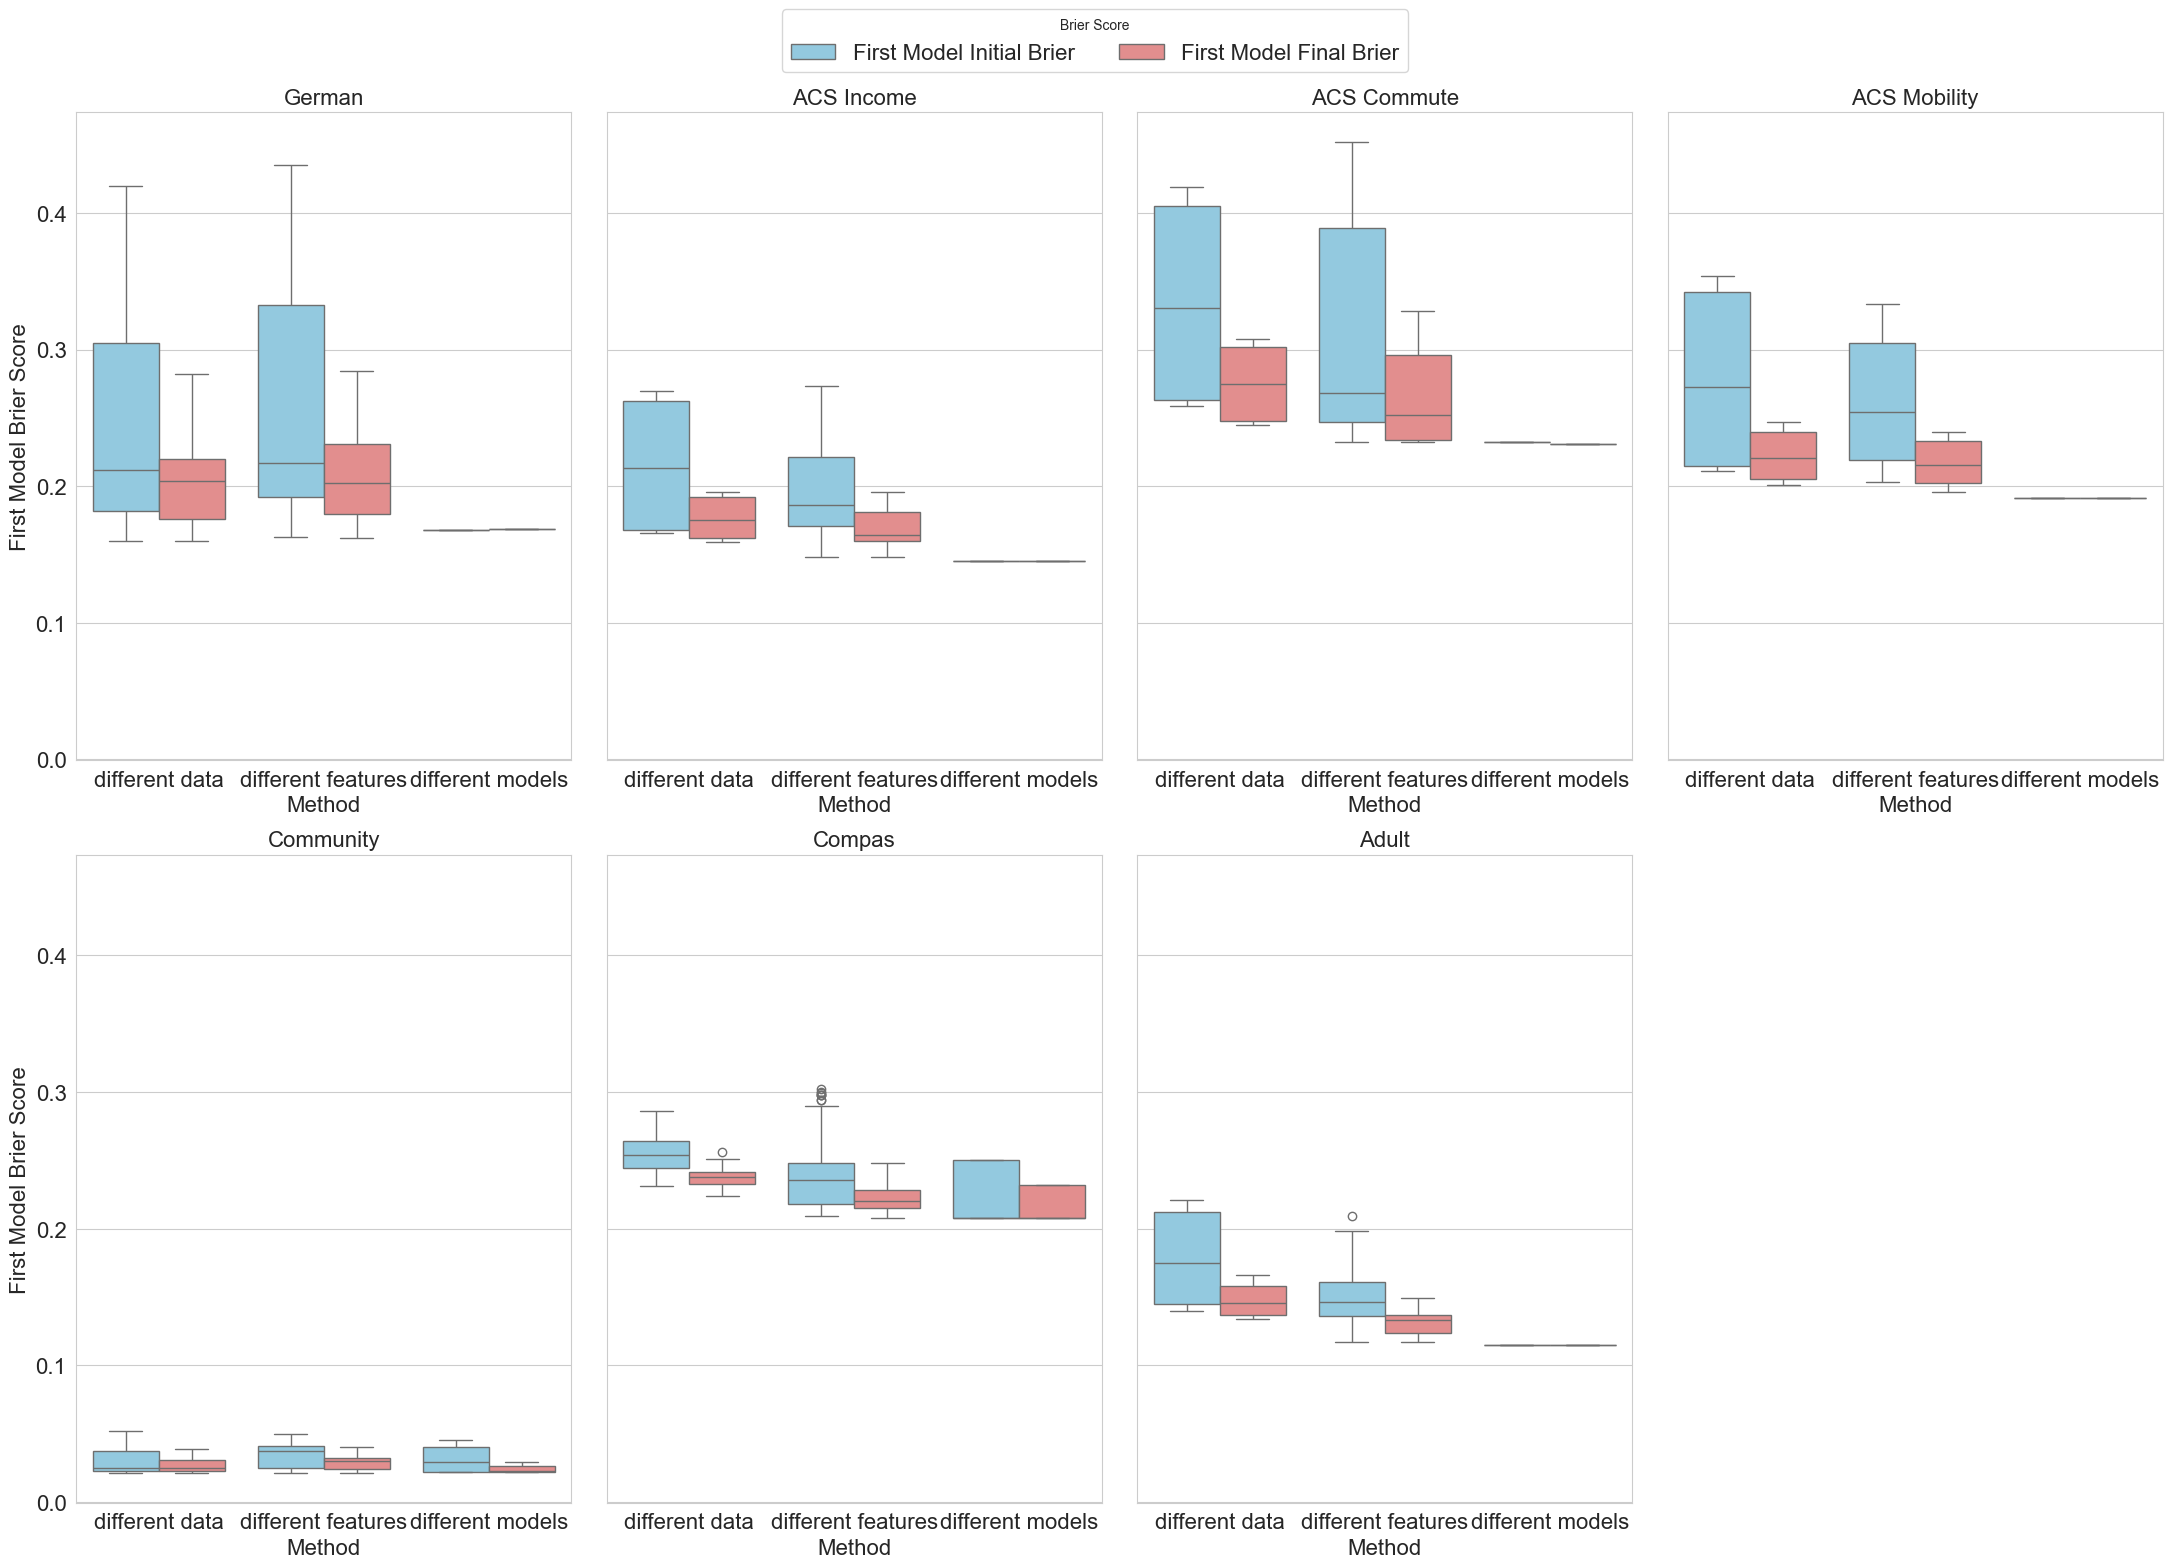

In [27]:
datasets = df['Data'].unique()
df['First Model Initial Brier'] = df['Initial Brier'].apply(lambda x: ast.literal_eval(x)[0])
df['First Model Final Brier'] = df['Final Brier'].apply(lambda x: ast.literal_eval(x)[0])
# Set up the figure and subplots: 7 subplots for 7 datasets (arranged in a grid, e.g., 2 rows and 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(22, 15), sharey=True)  # 2x4 grid (even though we only need 7)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define colors for Initial and Final Disagreements
initial_color = 'skyblue'
final_color = 'lightcoral'

# Loop over each dataset and plot the corresponding boxplots
for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Filter the dataframe for the current dataset
    df_subset = df[df['Data'] == dataset]
    
    # Reshape the data for box plotting (to create separate boxplots for Initial and Final Disagreement)
    df_melted = pd.melt(df_subset, id_vars=['Method'], 
                        value_vars=['First Model Initial Brier', 'First Model Final Brier'], 
                        var_name='Brier Type', value_name='Brier Score')
    
    # Plot the boxplots using seaborn
    sns.boxplot(x='Method', y='Brier Score', hue='Brier Type', data=df_melted, 
                ax=ax, palette={'First Model Initial Brier': initial_color, 'First Model Final Brier': final_color})
    
    # Set the title for each subplot
    ax.set_title(f'{dataset}', fontsize=16)
    
    # Set labels for each subplot
    ax.set_xlabel('Method', fontsize=16)
    ax.set_ylabel('First Model Brier Score', fontsize=16)
    # Remove the legend for individual plots (we'll add a global one later)
    ax.get_legend().remove()

# Turn off the 8th (extra) subplot, as we only need 7
if len(axes) > len(datasets):
    fig.delaxes(axes[-1])
    # fig.delaxes(axes[-2])# This removes the 8th axis

# Adjust layout to fit everything nicely
plt.tight_layout()

# Add a global legend (for the whole figure) that differentiates Initial vs Final Disagreement
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Brier Score', bbox_to_anchor=(0.5, 1.05), fontsize=16)

plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['xtick.labelsize'] = 16  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size
plt.rcParams['axes.titlesize'] = 16 
# Show the plot
plt.show()